# "Computational annotation of doublets with scds on Seurat object"

>"Only takes 3 min!"

- toc: false
- branch: master
- badges: true
- comments: false
- categories: [R, jupyter, singlecell, Seurat, scds]
- image: images/doublet.png
- hide: false

Sometimes when we see an "unexpectied" cluster or group, one of the possible causes could be doublets. Treating doublets as single cells in downstream analyses can bias a study’s conclusions. Here we can use *scds*, which implamented two new approaches to identify doublets(Co-expression based doublet scoring **cxds** and binary classification based doublet scoring **bcds**) to elaluate doublets scores.

For more guides, check scds's [page](https://bioconductor.org/packages/devel/bioc/vignettes/scds/inst/doc/scds.html).

In [2]:
set.seed(8887)

In [ ]:
library(scds, verbose = FALSE)
library(scater, verbose = FALSE)
library(rsvd, verbose = FALSE)
library(Rtsne, verbose = FALSE)
library(cowplot, verbose = FALSE)
library(scater, verbose = FALSE)
library(patchwork, verbose = FALSE)
library(Seurat, verbose = FALSE)
library(SeuratData, verbose = FALSE)
library(dplyr)

We first load the data (download available [here](https://www.dropbox.com/s/cuowvm4vrf65pvq/allen_cortex.rds?dl=1)), it's a reference scRNA-seq dataset of ~14,000 adult mouse cortical cell taxonomy from the Allen Institute, generated with the SMART-Seq2 protocol.

In [4]:
allen_reference <- readRDS("~/Documents/blog_notes/allen_cortex.rds")

In [5]:
brain.ref.sce <- as.SingleCellExperiment(allen_reference)

In [6]:
dim(brain.ref.sce)

[1] 34617 14249

In [7]:
table(brain.ref.sce$subclass)


     Astro         CR       Endo    L2/3 IT         L4      L5 IT      L5 PT 
       368          7         94        982       1401        880        544 
     L6 CT      L6 IT        L6b      Lamp5 Macrophage      Meis2         NP 
       960       1872        358       1122         51         45        362 
     Oligo       Peri      Pvalb   Serpinf1        SMC       Sncg        Sst 
        91         32       1337         27         55        125       1741 
       Vip       VLMC 
      1728         67 

Visualize:

In [8]:
logcounts(brain.ref.sce) = log1p(counts(brain.ref.sce))
vrs = apply(logcounts(brain.ref.sce),1,var)
pc = rpca(t(logcounts(brain.ref.sce)[order(vrs,decreasing=TRUE)[1:100],]))
ts = Rtsne(pc$x[,1:10],verb=FALSE)

In [9]:
options(repr.plot.width=12, repr.plot.height=8)

In [10]:
reducedDim(brain.ref.sce,"tsne") = ts$Y; rm(ts,vrs,pc)

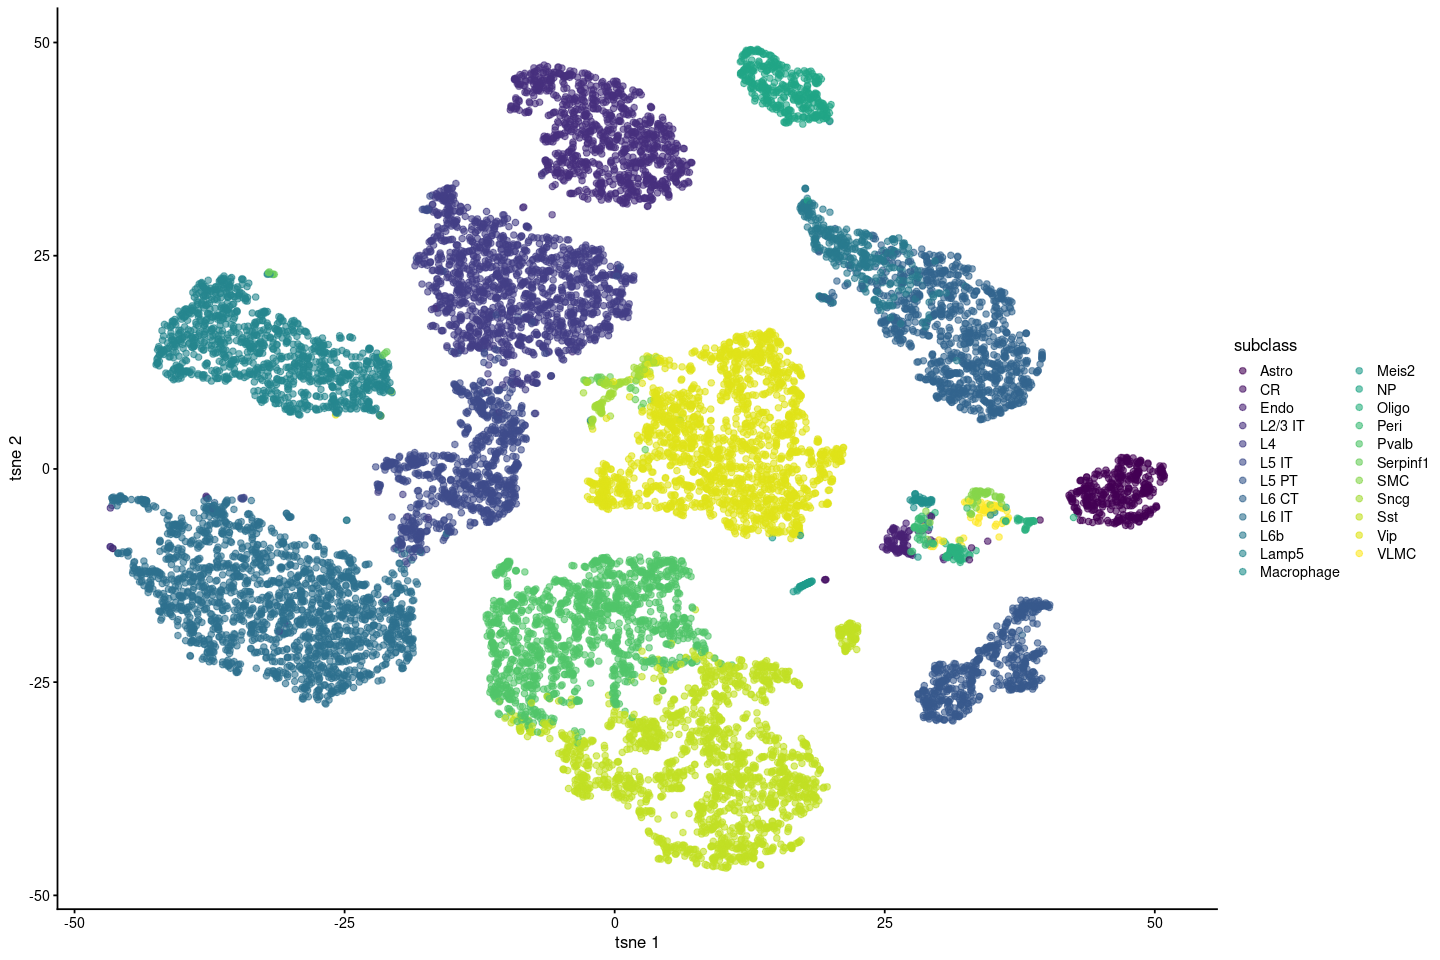

In [11]:
plotReducedDim(brain.ref.sce,"tsne",col="subclass")

# Annotate doublet using co-expression based doublet scoring

In [12]:
brain.ref.sce = cxds(brain.ref.sce,retRes = TRUE)
brain.ref.sce = bcds(brain.ref.sce,retRes = TRUE,verb=TRUE)

-> selecting genes


-> simulating doublets


-> training classifier




[01:32:23] WARNING: amalgamation/../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


-> done.





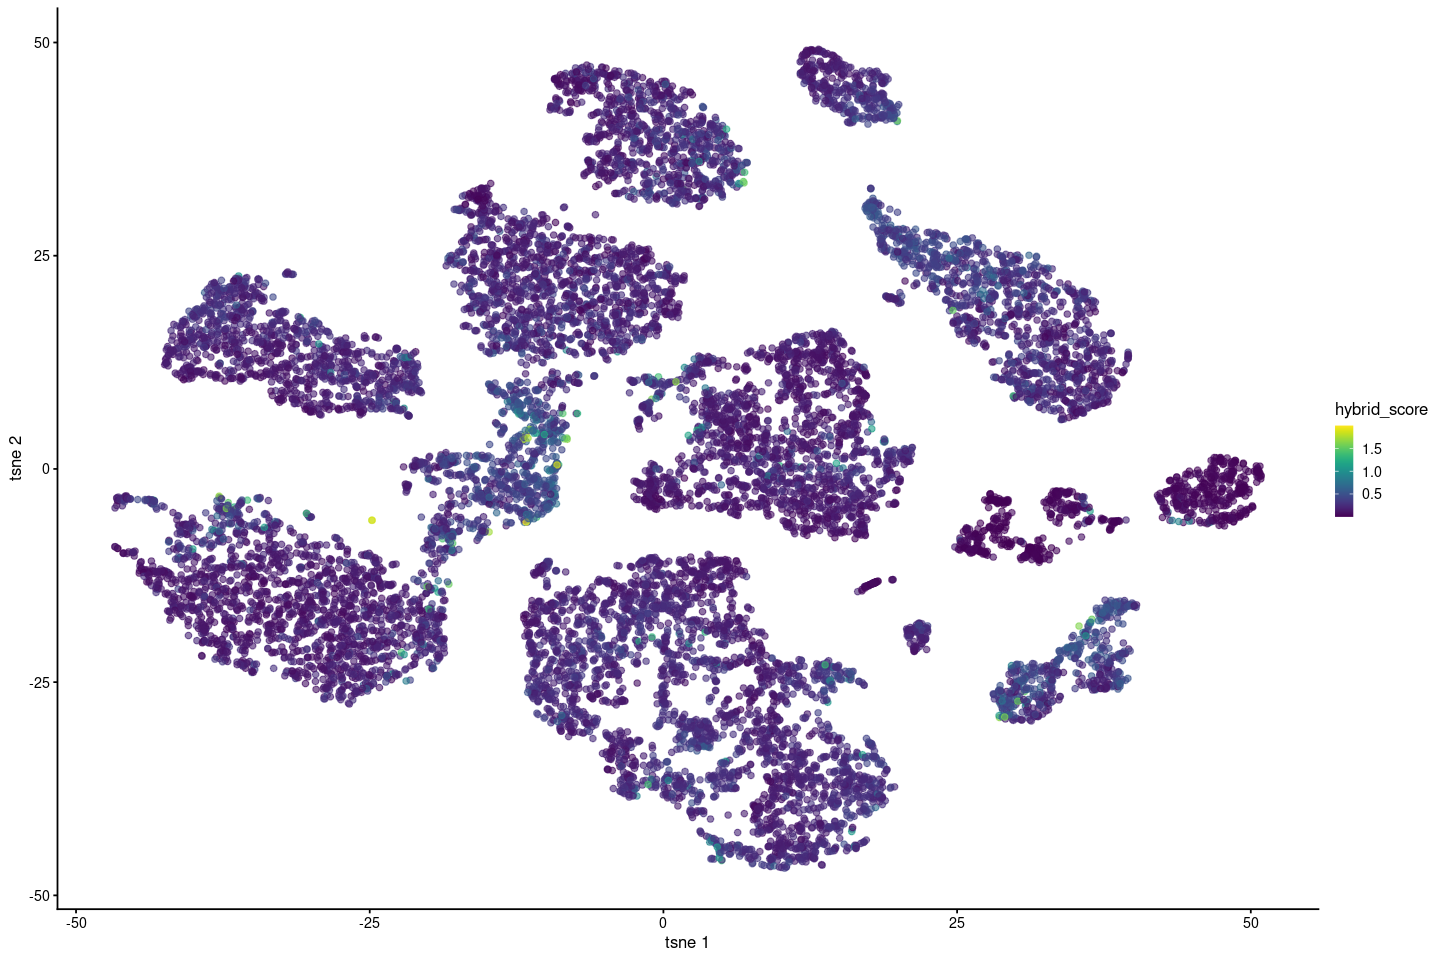

In [13]:
brain.ref.sce = cxds_bcds_hybrid(brain.ref.sce)
plotReducedDim(brain.ref.sce,"tsne",col="hybrid_score")

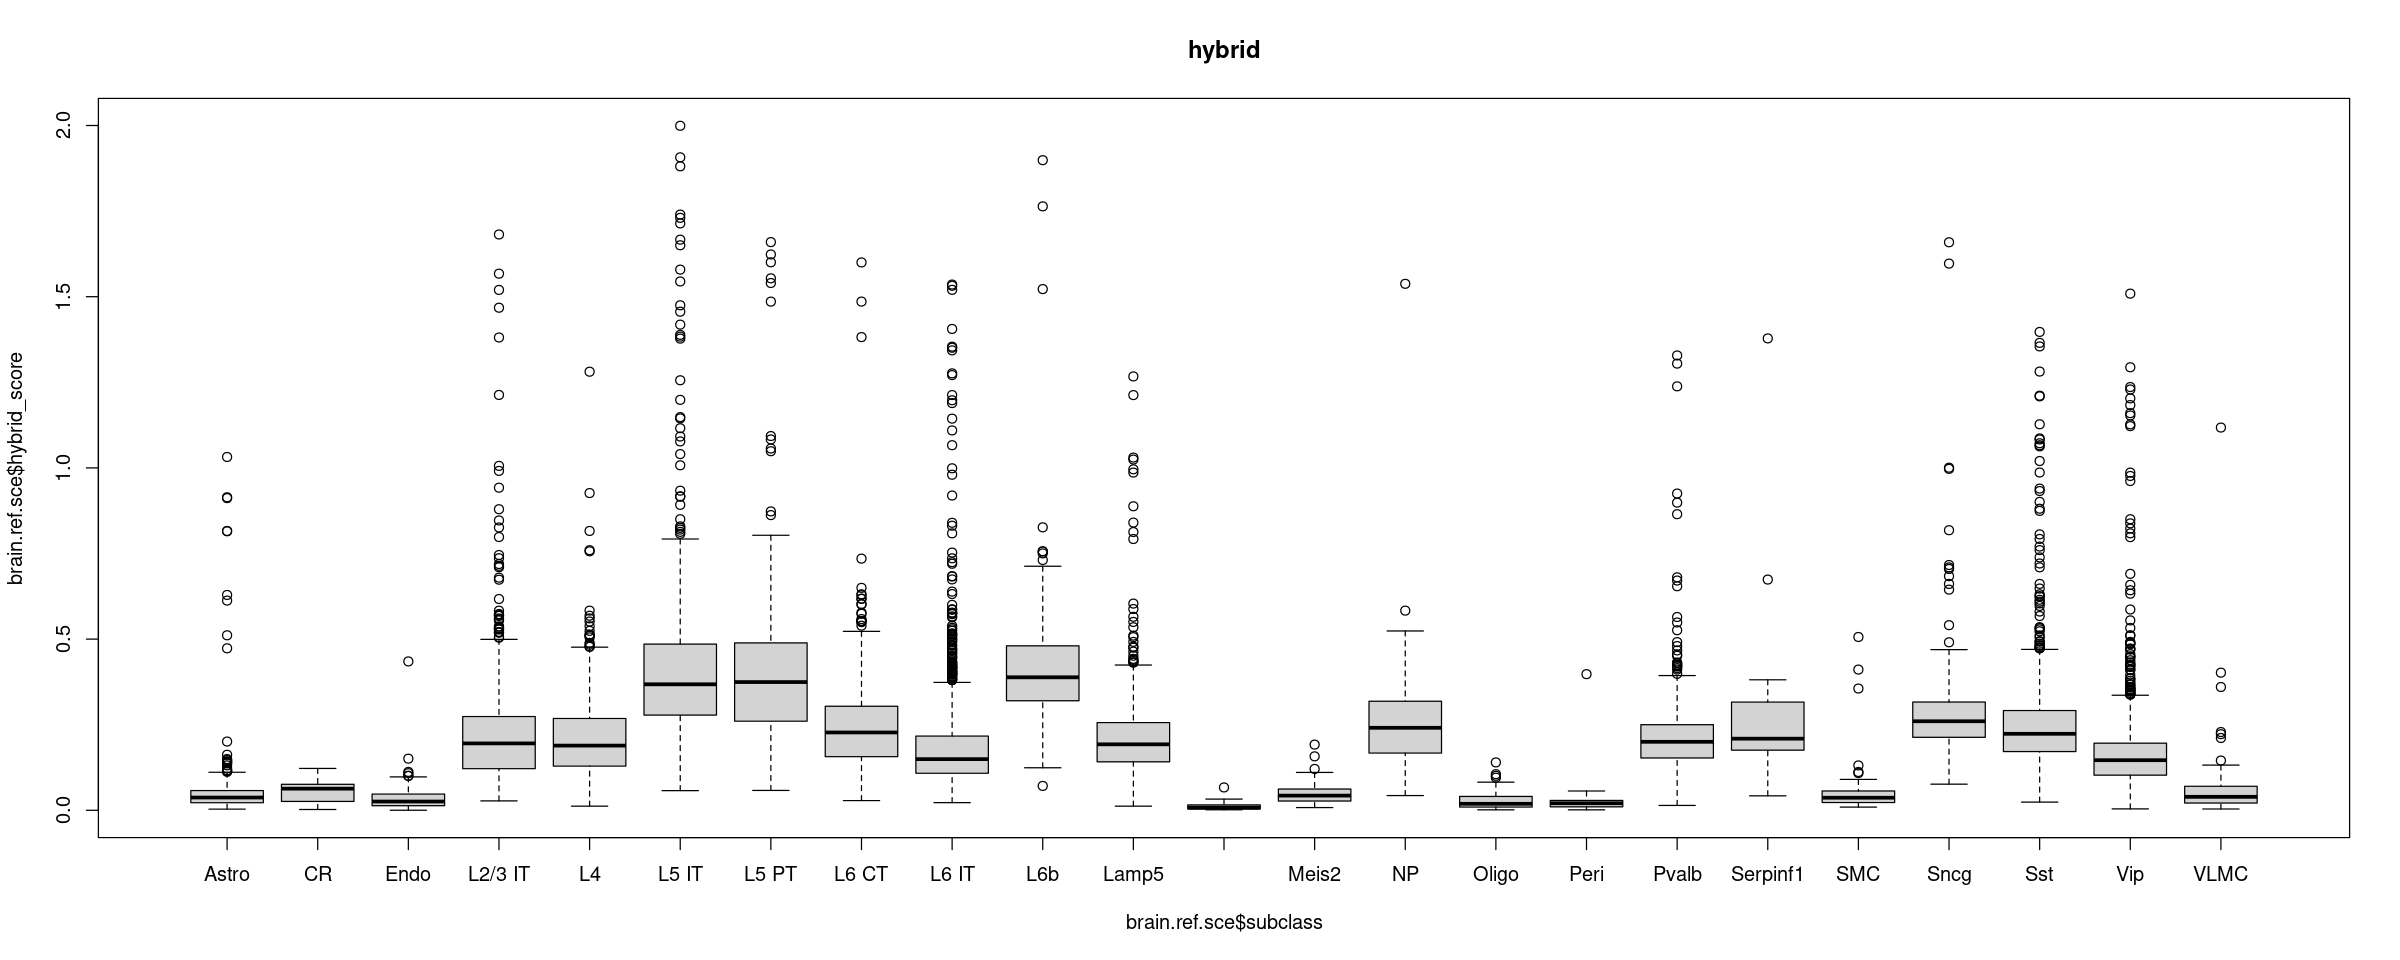

In [14]:
options(repr.plot.width=20, repr.plot.height=8)
boxplot(brain.ref.sce$hybrid_score ~ brain.ref.sce$subclass, main="hybrid")

# Export scores and load it back into thge original Seurat object:

In [15]:
metadata = as.data.frame(colData(brain.ref.sce))
hyb_doublet_score = select(metadata, hybrid_score)

In [16]:
allen_reference <- AddMetaData(allen_reference, metadata = hyb_doublet_score, col.name = 'hybrid.score')

In [17]:
allen_reference_3000 <- allen_reference[,sample(colnames(allen_reference), size =3000, replace=F)]

In [ ]:
allen_reference_3000 <- SCTransform(allen_reference_3000, ncells = 3000, verbose = FALSE) %>%
    RunPCA(verbose = FALSE)  %>%
    RunUMAP(dims = 1:30)

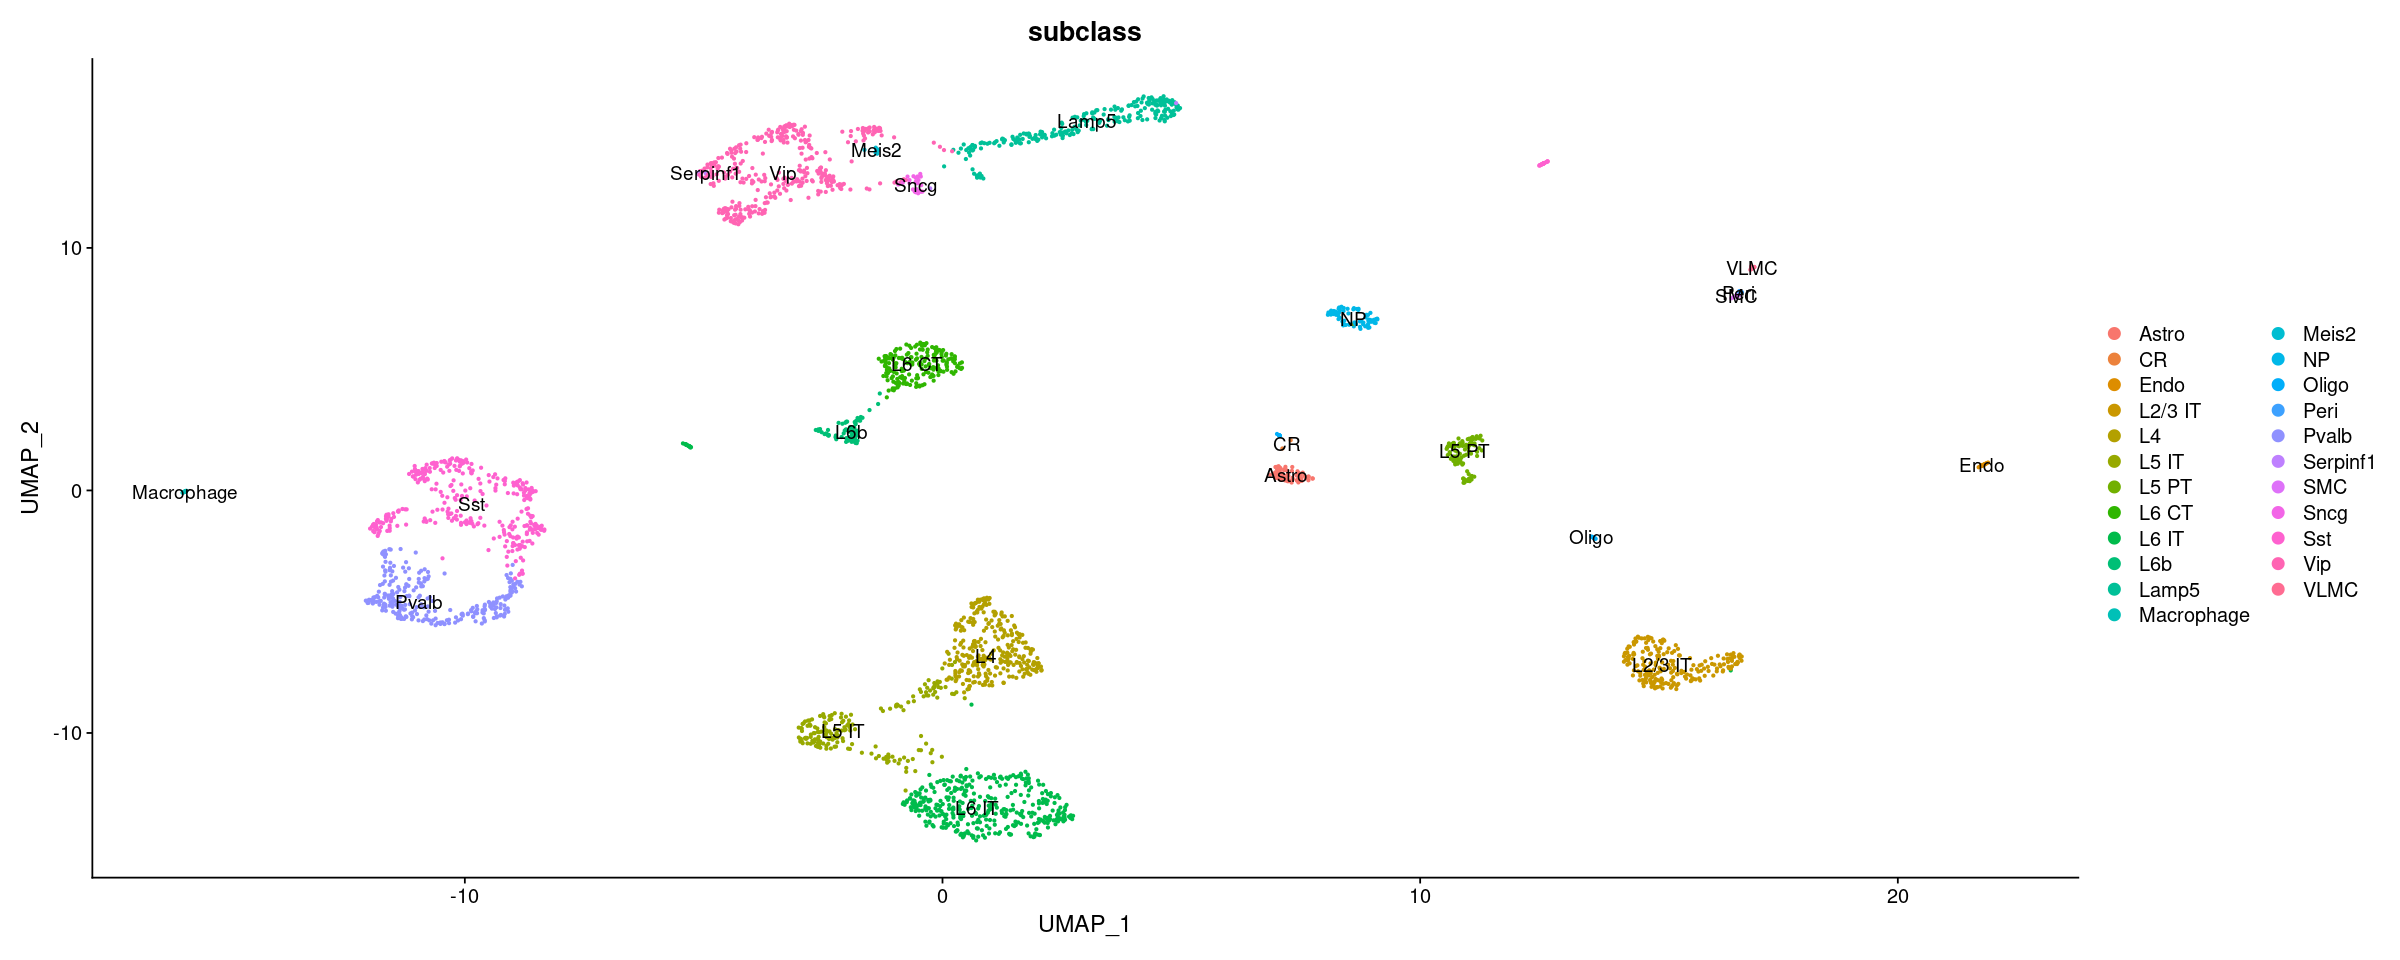

In [19]:
# the annotation is stored in the 'subclass' column of object metadata
DimPlot(allen_reference_3000, group.by = "subclass", label = TRUE)

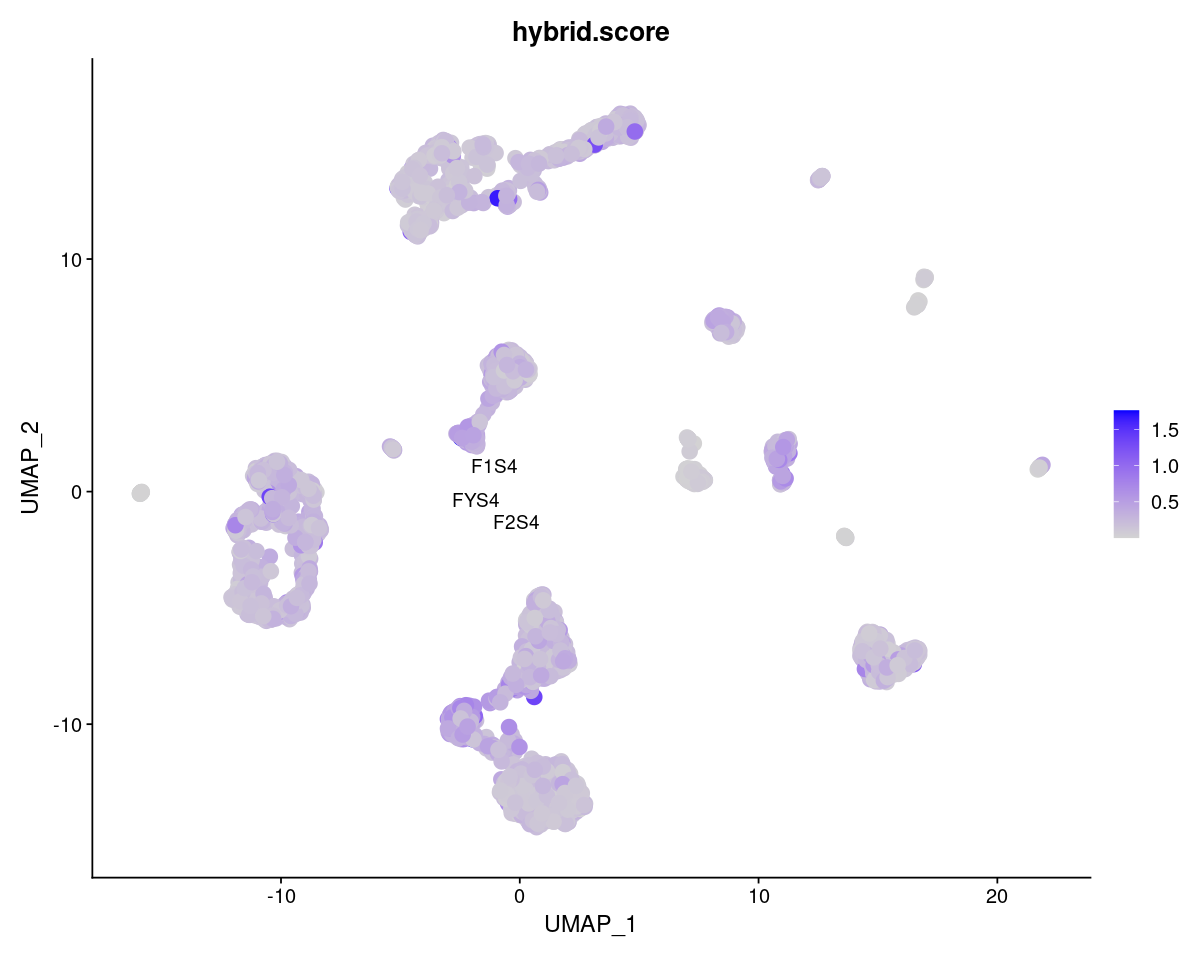

In [24]:
options(repr.plot.width=10, repr.plot.height=8)
FeaturePlot(allen_reference_3000, features = "hybrid.score", label = TRUE, pt.size=4)

3 min is a lie :cake:

## Session information

In [25]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dplyr_1.0.8                 stxBrain.SeuratData_0.1.1  
 [3] SeuratData_0.2.1            SeuratObject_4.0.4         
 [5] Seurat_4.1.0                patchwork_1.1.1            
 [7] cowplot_1.1.1               Rtsne_0.15                